# Problem need to be addressed 

In this research, we proposal a new fault tolerance analysis technique - fault tolerance boundary is designed specific to the data variables.

why the huristic work, or why it does not work.


# Can you think a neural network method to understand program's property?
# Understand the propagation value of the nearest neighbor.
# Sampling method



1. What's the fault tolerance boundary.
2. It's a technique can be equivlent to the fault injection campaign.
3. We propose a method to approximate the boundary.
    1. heuristic method to measure the boundary.
    2. correlation analysis between variables to understand the relationship between the fault tolerance across variables.
4. label propagation and active learning.
5. The why masked prediction fail also can we use the SDC run to predict the program's outcome

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import os.path
import matplotlib.pyplot as plt
import random
import math
from IPython.core.debugger import set_trace
from datetime import datetime
import sys
import time
from utility.sampling import adaptiveSampling, activeSampling

random.seed(datetime.now())

In [2]:
DATASET = "lu" #current available datasets fft, lu, cg, other potential dataset.,

In [3]:
# Threshold that used to decide whether the final outcome is SDC or Masked. For the loading data
# set, there are two different datasets. One is the exhaust fault injection campaign which contains
# all the fault injection information. The other is the test data set which is the sample experiment 
# contain the detail propagation information used for the downstream propagation analysis.
PROPAGATION_DATA_PATH = ""
CAMPAIGN_DATA_PATH = ""
PROPAGATION_INJECTION_DATA_PATH = ""
THRESHOLD = 0
BIT_SIZE = 0

if DATASET == "fft":
    PROPAGATION_DATA_PATH = "../static/data/fft/fft_benchmark"
    CAMPAIGN_DATA_PATH = "../static/data/fft/fft_injectlog.log"
    THRESHOLD = 0.001
    BIT_SIZE = 64
elif DATASET == "cg":
    PROPAGATION_DATA_PATH = "../static/data/cg/cg_in8"
    CAMPAIGN_DATA_PATH = "../static/data/cg/cg_in8/injectlog.log"
    THRESHOLD = 0.07
    BIT_SIZE = 64
elif DATASET == "lu":
    PROPAGATION_DATA_PATH = "../static/data/lu/lu20000"
    CAMPAIGN_DATA_PATH = "../static/data/lu/injectlog.log"
    THRESHOLD =  0.00001
    BIT_SIZE = 64
elif DATASET == "bs":
    PROPAGATION_DATA_PATH = "../static/data/bs/bs"
    CAMPAIGN_DATA_PATH = "../static/data/bs/injectlog_complete.log"
    THRESHOLD = 0.0001
    BIT_SIZE = 32
elif DATASET == "spmv":
    PROPAGATION_DATA_PATH = "../static/data/spmv/"
    CAMPAIGN_DATA_PATH = "../static/data/spmv/injectlog_complete.log"
    THRESHOLD = 0.0001
    BIT_SIZE = 64
     
# The fault injection campaign experiment
FAULT_INJECTION_CAMPAIGN = pd.read_csv(CAMPAIGN_DATA_PATH,  sep=" ", names=['fileindex', 'file', 'linenum', 'variable','byte_num', 'corrupted','init_value','to', 'corrupt_value', 'mask', 'byte','expo', 'ss', 'op', 'diffnorm', 'empty'])

# The size of the fault injection experiment
SIZE = len(FAULT_INJECTION_CAMPAIGN)

# The percentage of the test experiment over exhaust fault injection campaign.
TEST_EXPERIMENT_NUMBER = int(SIZE * 0.1)

# Golden Run
GOLDEN_RUN = pd.read_csv(PROPAGATION_DATA_PATH+"/golden.log",  sep=" ", names=['linenum', 'variable', 'value'])
TEST_EXPERIMENTS = FAULT_INJECTION_CAMPAIGN.sample(n=TEST_EXPERIMENT_NUMBER, replace=True)
#TEST_EXPERIMENTS = adaptiveSampling(FAULT_INJECTION_CAMPAIGN, GOLDEN_RUN, PROPAGATION_DATA_PATH, THRESHOLD)
#TEST_EXPERIMENTS = FAULT_INJECTION_CAMPAIGN.loc[TEST_EXPERIMENTS,:]
#TEST_EXPERIMENTS = pd.read_csv(PROPAGATION_DATA_PATH+"/injectlog.log",  sep=" ", names=['fileindex', 'file', 'linenum', 'variable','byte_num', 'corrupted','init_value','to', 'corrupt_value', 'mask', 'byte','expo', 'ss', 'op', 'diffnorm', 'empty'])

# SDC ratio of test experiments
SDC_COUNT = 0
FAULT_INJECTION_CAMPAIGN['diffnorm'] = FAULT_INJECTION_CAMPAIGN['diffnorm'].astype(float)
SDC_COUNT = len(FAULT_INJECTION_CAMPAIGN.loc[FAULT_INJECTION_CAMPAIGN['diffnorm'] > THRESHOLD])
        
print("The SDC ratio in this experiment is",SDC_COUNT/len(FAULT_INJECTION_CAMPAIGN))
print("The size of the exhaust fault injection experiments", len(FAULT_INJECTION_CAMPAIGN))
print("THe size of Masked case in fault injection experiments", (1 - SDC_COUNT/len(FAULT_INJECTION_CAMPAIGN)) *  len(FAULT_INJECTION_CAMPAIGN))

The SDC ratio in this experiment is 0.39011318312966736
The size of the exhaust fault injection experiments 754176
THe size of Masked case in fault injection experiments 459962.0


# Golden Fault Injection Boundary
Golden fault injection boundary use the exhaust fault inject campaign to build the boundary in practical sense. If the error value is above a specific threshold, then the location will not tolerance the error.

In [4]:
# In fault injection campaign analysis, the prediction outcome is positive and negative.
# during the prediction process, we ignore the crash case.
# For the prediction, we need to think about four different cases
# True negative, False positive
# False negative, True positive
def predict(boundary):
    positive_prediction = 0
    crash = 0
    negative_prediction = 0
    result = {}
    bits = []
    nan = float('nan')
    inf = float('inf')
    
    mitigation_set = {}
    count = 0

    for index, row in FAULT_INJECTION_CAMPAIGN.iterrows():
        instruction_index = int(row["byte_num"].split("#")[1])
        inject_error = 0
        corrupt_value = float(row['corrupt_value'])
        init_value = float(row['init_value'])
        
        if init_value != 0 and corrupt_value != nan and corrupt_value != inf:
            #relative error:  inject_error = abs((corrupt_value - init_value)/init_value)
            inject_error = abs(corrupt_value - init_value)
        
        diffnorm = float(row['diffnorm'])            
        
        if inject_error < boundary[instruction_index]:
            if diffnorm < THRESHOLD:
                positive_prediction += 1
            elif math.isnan(diffnorm) or math.isinf(diffnorm):
                crash += 1
            else:
                negative_prediction += 1 
  
    result["positive"] = positive_prediction
    result["negative"] = negative_prediction
    result["crash"] = crash
    result["accuracy"] = positive_prediction/(positive_prediction + negative_prediction)
    
    return (result, bits)

def getGoldenFaultToleranceBoundary():
    nan = float('nan')
    inf = float('inf')
    
    #boundary = np.full(len(GOLDEN_RUN), np.inf)
    boundary = np.zeros(len(GOLDEN_RUN))
    masked_max = 0
    for index, row in FAULT_INJECTION_CAMPAIGN.iterrows():
        corrupt_value = float(row['corrupt_value'])
        init_value = float(row['init_value'])
        inject_error = 0
        norm = float(row["diffnorm"])
        
        try:
            instruction_index = int(row["byte_num"].split("#")[1])
        except:
            print(row)
        
        if corrupt_value != nan and corrupt_value != inf:
            #inject_error = abs((corrupt_value - init_value)/init_value)
            inject_error = abs(corrupt_value - init_value)
          
            if norm > THRESHOLD:
                if boundary[instruction_index] == 0:
                    boundary[instruction_index] = inject_error
                else:                       
                    boundary[instruction_index] = min(inject_error, boundary[instruction_index])
            elif norm <= THRESHOLD:
                masked_max = max(inject_error, masked_max)

            #if instruction_index == 137:
            #    print(inject_error, masked_max)
                
            if (index+1) % BIT_SIZE == 0: 
                if boundary[instruction_index] == 0:
                    boundary[instruction_index] = masked_max*1.0000001 + 0.01
                masked_max = 0
            
            
            
    return boundary

def getGoldenSDCRatioOverTime():
    sdc_ratio_over_time = np.zeros(len(GOLDEN_RUN))
    nan = float('nan')
    inf = float('inf')
    
    for index, row in FAULT_INJECTION_CAMPAIGN.iterrows():
        instruction_index = int(row['byte_num'].split('#')[1])
        norm = float(row["diffnorm"])
        inject_error = abs(float(row['init_value']) - float(row['corrupt_value']))
        
        
        
        if norm > THRESHOLD and norm != nan and norm != inf and inject_error != inf and inject_error != nan:
            sdc_ratio_over_time[instruction_index]+=1
        
    return sdc_ratio_over_time/BIT_SIZE

# How does the number of samples affect the approximation

In [5]:
tracking_length = len(GOLDEN_RUN.value)
def construct_boundary(cases):
    boundary = np.zeros(tracking_length)
    for index, row in cases.iterrows():
        index = row['fileindex']
        masked_run_path = PROPAGATION_DATA_PATH +"/appstate_"+ str(index) + ".log"
        #print(masked_run_path)
        #Check whether the tracking file is on the path
        #TODO: check whether can regenerate the data
        #print(masked_run_path)
        if not os.path.isfile(masked_run_path):
            print("file does not exist")
            continue

        masked_run = pd.read_csv(masked_run_path,  sep=" ", names=['file', 'linenum', 'variable', 'value'])
        masked_run_value = np.array(masked_run.value, dtype='double')

        #This is a werid information in the data.
        #TODO: may check why such outcome is shown
        if len(masked_run_value) < tracking_length:
            print("odd!")
            continue

        #array contain NAN, ignore the run
        if np.isnan(np.min(masked_run_value)):
            continue

        #filter operation
        comparision_result = np.abs(masked_run_value[0:tracking_length] - GOLDEN_RUN.value)

        result = predict(comparision_result, cases)
        if result[0]['accuracy'] < 1 :
            continue

        for j in range(tracking_length):
            if comparision_result[j] > boundary[j]:
                boundary[j] = comparision_result[j]
    return boundary

def construct_boundry_optimize(experiments):
    sdc_boundary = []
    golden_run_value = np.array(GOLDEN_RUN.value, dtype='double')

    count = 0
    sdc_boundary = np.zeros(tracking_length)
    #for i in range(tracking_length):
    #    sdc_boundary.append(0)

    experiments['diffnorm'] = experiments['diffnorm'].astype(float)
    sdc_experiments = experiments.loc[experiments['diffnorm'] > THRESHOLD]

    # set up a approximate sdc boundary value.
    for index, row in sdc_experiments.iterrows():
        instruction_index = int(row['byte_num'].split('#')[1])
        
        inject_error = abs(float(row['init_value']) - float(row['corrupt_value']))
        
        if sdc_boundary[instruction_index] != 0:
            sdc_boundary[instruction_index] = min(sdc_boundary[instruction_index], inject_error)
        else:
            sdc_boundary[instruction_index] = inject_error

    #sdc_boundary = np.array(sdc_boundary)
    sdc_index = np.where(sdc_boundary > 0)[0]


    masked_run_collections = []
    masked_experiments = experiments.loc[experiments['diffnorm'] < THRESHOLD]

    for index, row in masked_experiments.iterrows():
        instruction_index = int(row['byte_num'].split('#')[1])
        inject_error = abs(float(row['init_value']) - float(row['corrupt_value']))

        masked_run_path = PROPAGATION_DATA_PATH +"/appstate_"+ str(index) + ".log"
        masked_run = pd.read_csv(masked_run_path,  sep=" ", names=['linenum', 'variable', 'value'])
        masked_run_value = np.array(masked_run.value, dtype='float')

        if len(masked_run_value) < tracking_length:
            print("odd!")
            continue
        
        #array contain NAN, ignore the run
        if np.isnan(np.min(masked_run_value)):
            continue

        masked_run_value = masked_run_value[0:tracking_length] - golden_run_value      
        #temp = masked_run_value[sdc_index] - sdc_boundary[sdc_index]
        #if np.sum(temp > 0) > 0:
        #    continue

        masked_run_collections.append(masked_run_value)
    boundary = np.max(masked_run_collections, axis=0)
    
    idx = boundary == 0
    boundary[idx] += np.nextafter(0,1)
    return boundary
def predict_sdc_ratio_over_time(boundary, experiments):
    sdc_ratios_of_instructions = np.zeros(tracking_length)
    nan = float('nan')
    inf = float('inf')
    
    for index, row in experiments.iterrows():
        instruction_index = int(row['byte_num'].split("#")[1])
        inject_error = abs(float(row['init_value']) - float(row['corrupt_value']))
        diffnorm = float(row['diffnorm'])
                
        if inject_error > boundary[instruction_index] and inject_error != nan and inject_error != inf:
            sdc_ratios_of_instructions[instruction_index] += 1

    return sdc_ratios_of_instructions/BIT_SIZE

def random_sampling_sdc_ratio_overtime(experiment):
    sdc_ratios_of_instructions = np.zeros(tracking_length)
    for index, row in experiment.iterrows():
        diffnorm = float(row['diffnorm'])
        instruction_index = int(row['byte_num'].split('#')[1])
        if diffnorm > THRESHOLD:
            sdc_ratios_of_instructions[instruction_index] += 1
    return sdc_ratios_of_instructions/BIT_SIZE

def optimize_predict(boundary, experiments):
    positive_prediction = 0
    crash = 0
    negative_prediction = 0
    result = {}
    bits = []

    for index, row in experiments.iterrows():
        instruction_index = int(row['byte_num'].split('#')[1])
        inject_error = abs(float(row['init_value']) - float(row['corrupt_value']))
        diffnorm = float(row['diffnorm'])

        if inject_error < boundary[instruction_index]:
            if diffnorm <= THRESHOLD:
                 positive_prediction += 1
            elif math.isnan(diffnorm) or math.isinf(diffnorm):
                crash += 1
            else:
                negative_prediction += 1 

    result["positive"] = positive_prediction
    result["negative"] = negative_prediction
    result["crash"]    = crash
    result["accuracy"] = positive_prediction/(positive_prediction + crash + negative_prediction)
    result['prediction']  = 1-(positive_prediction + crash + negative_prediction)/len(experiments)
    return result

boundary = getGoldenFaultToleranceBoundary()
golden_pre = predict_sdc_ratio_over_time(boundary, FAULT_INJECTION_CAMPAIGN)

np.savetxt('gb.out', golden_pre, delimiter=',')
#case = TEST_EXPERIMENTS
#boundary = construct_boundry_optimize(case)
#sample_pre = predict_sdc_ratio_over_time(boundary, FAULT_INJECTION_CAMPAIGN)

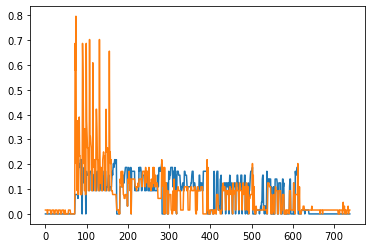

In [18]:
plt.plot(golden_pre)
plt.plot(sample_pre)

In [ ]:

'''
gol = getGoldenSDCRatioOverTime()
step_size = 20
step = int(len(gol)/step_size)

random_result = []
idx = []

# get 100 random fault injection experiments with 1% samples and predict the sdc ratio overtime
for _ in range(100):
    case = FAULT_INJECTION_CAMPAIGN.sample(n=TEST_EXPERIMENT_NUMBER, replace=True)
    exp = gol - random_sampling_sdc_ratio_overtime(case)
    m = []   
    for i in range(step-1):
        start = int(i*step_size)
        nexts = int((i+1) * step_size)
        m.append(np.mean(exp[start:nexts]))
    m.append(np.mean(exp[i * step_size:]))
    random_result.append(m)
    
    
# get 100 adaptive sampling experiment with 1% samples and predict the sdc ratio overtime
adaptive_result = []
prediction_result = []
accuracy_result = []
for _ in range(100):
    case = adaptiveSampling(FAULT_INJECTION_CAMPAIGN, GOLDEN_RUN, PROPAGATION_DATA_PATH, 0.005, THRESHOLD)
    boundary = construct_boundry_optimize(case)
    prediction_result.append(optimize_predict(boundary, FAULT_INJECTION_CAMPAIGN)['prediction'])
    accuracy_result.append(optimize_predict(boundary, FAULT_INJECTION_CAMPAIGN)['accuracy'])
    exp = gol - predict_sdc_ratio_over_time(boundary, FAULT_INJECTION_CAMPAIGN)
    m = []   
    for i in range(step-1):
        start = int(i*step_size)
        nexts = int((i+1) * step_size)
        m.append(np.mean(exp[start:nexts]))
    m.append(np.mean(exp[i * step_size:]))
    adaptive_result.append(m)
    
for i in range(step-1):  
    idx.append(i*step_size + step_size/2)
idx.append((i*step_size + len(gol))/2)
    
print(np.mean(prediction_result), np.std(prediction_result))    
#sdc_ratio_overtime_experiments = []
#result = []
#boundarys = []

#case = adaptiveSampling(FAULT_INJECTION_CAMPAIGN, GOLDEN_RUN, PROPAGATION_DATA_PATH, THRESHOLD)
#case = TEST_EXPERIMENTS = pd.read_csv(PROPAGATION_DATA_PATH+"/injectlog.log",  sep=" ", names=['fileindex', 'file', 'linenum', 'variable','byte_num', 'corrupted','init_value','to', 'corrupt_value', 'mask', 'byte','expo', 'ss', 'op', 'diffnorm', 'empty'])
#boundary = construct_boundry_optimize(case)
#prediction = optimize_predict(boundary, FAULT_INJECTION_CAMPAIGN)
'''

#gol = getGoldenSDCRatioOverTime()

#boundary = construct_boundry_optimize(TEST_EXPERIMENTS)
#prediction = optimize_predict(boundary, FAULT_INJECTION_CAMPAIGN)
#step_size = 20
#step = int(len(gol)/step_size)
#idx = []



#res = []
#acu = []
#for _ in range(1):
#    print(_)
    #case = FAULT_INJECTION_CAMPAIGN.sample(n=TEST_EXPERIMENT_NUMBER, replace=True)
#    case =  adaptiveSampling(FAULT_INJECTION_CAMPAIGN, GOLDEN_RUN, PROPAGATION_DATA_PATH, 0.005, THRESHOLD)
#    boundary = construct_boundry_optimize(case)
#    pre = optimize_predict(boundary, FAULT_INJECTION_CAMPAIGN)
#    res.append(pre['prediction'])
#    acu.append(pre['accuracy'])

#print(np.mean(res), np.std(res))
#print(np.mean(acu), np.std(acu))


#exp = predict_sdc_ratio_over_time(boundary, FAULT_INJECTION_CAMPAIGN)
    #exp = random_sampling_sdc_ratio_overtime(case)
#    res = exp

#    m = []   
#    for i in range(step-1):
#        start = int(i*step_size)
#        nexts = int((i+1) * step_size)
#        m.append(np.mean(res[start:nexts]))
#    result.append(m)

    

#plt.errorbar(idx, np.mean(result, axis=0), np.std(result, axis=0), fmt='o', capsize=15, linewidth =2, ms=10)     
    
#for _ in range(100):
#    print(_)
#    case =  adaptiveSampling(FAULT_INJECTION_CAMPAIGN, GOLDEN_RUN, PROPAGATION_DATA_PATH, THRESHOLD)
#    boundary = construct_boundry_optimize(case)
#    prediction = optimize_predict(boundary, FAULT_INJECTION_CAMPAIGN)
#    result.append(1 - prediction['sum']/float(len(FAULT_INJECTION_CAMPAIGN)))
#print(np.mean(result))
#print(np.std(result))
#for num in [10, 100, 1000, 10000]:# 10000, 20000, 30000, 40000, 50000, 100000]:
#    for _ in range(100):
#        case = FAULT_INJECTION_CAMPAIGN.sample(n=num, replace=True)
#        case['diffnorm'] = case['diffnorm'].astype(float)
#        boundary = construct_boundry_optimize(case)
#        prediction = optimize_predict(boundary, FAULT_INJECTION_CAMPAIGN)
#        result.append([num, prediction['sum'], prediction['accuracy']])
#        boundarys.append(boundary)
#        print (num, _)

In [ ]:
print(np.mean(accuracy_result), np.std(accuracy_result))
plt.figure(figsize=(12, 10))
plt.errorbar(idx, np.mean(random_result, axis=0), np.std(random_result, axis=0), fmt='-o', capsize=15, linewidth =2, ms=10)     
plt.errorbar(idx, np.mean(adaptive_result, axis=0), np.std(adaptive_result, axis=0), fmt='-o', capsize=15, linewidth =2, ms=10) 
plt.xlabel('Dynamic Instruction Id.', fontsize=30)
plt.ylabel("Diff-SDC", fontsize=30)
plt.title('Conjugate Gradient', fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

In [ ]:
res = gol-exp
m = []
std = []
idx = []
step_size = 20

step = int(len(res)/step_size)

for i in range(step-1):
    start = int(i*step_size)
    nexts = int((i+1) * step_size)
    idx.append(i*step_size)
    m.append(np.median(res[start:nexts]))
    std.append(np.std(res[start:nexts]))

idx.append(i*step_size)
m.append(np.median(res[start:nexts]))
std.append(np.std(res[start:nexts]))
    
plt.figure(figsize=(12, 10))
plt.errorbar(idx, m, std, fmt='o', capsize=15, linewidth =2, ms=10)  
plt.xlabel('Dynamic Instruction Id.', fontsize=30)
plt.ylabel("Diff-SDC", fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)


In [ ]:
plt.hist(res, bins = 10)
plt.ylabel('num. of dynamic instruction', fontsize=20)
plt.xlabel("sdc ratio diffrence", fontsize=20)
#plt.xlabel('SDC ratio difference', fontsize=45)
#plt.ylabel("num. of fault injection sites", fontsize=35)
#plt.title('Black-scholes', fontsize=35)
#plt.xticks(rotation=45)
#plt.xticks(fontsize=25)
#plt.yticks(fontsize=25)
plt.plot()

In [ ]:
#result = list(result)
#result.append([47296, 43380, 1])
#plt.figure(figsize=(16, 10))
#exp = np.array(result)
#dataset = pd.DataFrame({"type":exp[:,0], "result":exp[:,1], "accuracy":exp[:,2]})
#id = list(set(dataset['type']))
#id.sort()
#id = np.array(id)/47296
#std =np.array(dataset.groupby(['type']).std()['result'])/43380.0
#m = np.array(dataset.groupby(['type']).mean()['result'])/43380.0

#p_std= np.array(dataset.groupby(['type']).std()['accuracy'])
#p_m = np.array(dataset.groupby(['type']).mean()['result'])

#plt.errorbar(id, p_m, p_std, fmt='-o', capsize=4)                
#plt.errorbar(id, m, std, fmt='-o', capsize=4)
#plt.xscale('log')
#plt.xlabel('sample size', fontsize=30)
#plt.ylabel("predict the percentage of Masked sample", fontsize=30)
#plt.title('Conjugate Gradient', fontsize=30)
#plt.xticks(rotation=45)
#plt.xticks(fontsize=25)
#plt.yticks(fontsize=25)
#plt.show()
#np.savetxt("result.txt", result, delimiter=',')
#result[:,2]

#print(1 - prediction['sum']/float(len(FAULT_INJECTION_CAMPAIGN)))
#print(prediction)

In [ ]:
golden_ratio_overtime = getGoldenSDCRatioOverTime()
sdc_ratio_overtime_experiments.append(predict_sdc_ratio_over_time(boundary, FAULT_INJECTION_CAMPAIGN))

In [ ]:
sdc_ratio_overtime_experiments.append(predict_sdc_ratio_over_time(boundary, FAULT_INJECTION_CAMPAIGN))

In [ ]:
i=0
gap = -1
abs_result = golden_ratio_overtime[i:gap] - sdc_ratio_overtime_experiments[0][i:gap]
plt.figure(figsize=(6, 18))
plt.subplot(311)
plt.plot(golden_ratio_overtime[i:gap])
plt.plot(sdc_ratio_overtime_experiments[0][i:gap])
plt.xlabel('dynamic instruction id', fontsize=20)
plt.ylabel("sdc ratio", fontsize=20)

plt.subplot(312)
plt.plot(abs_result)
plt.xlabel('dynamic instruction id', fontsize=20)
plt.ylabel("sdc ratio difference", fontsize=20)
plt.subplot(313)
plt.hist(abs_result, bins = 40)
plt.ylabel('num. of dynamic instruction', fontsize=20)
plt.xlabel("sdc ratio diffrence", fontsize=20)
#plt.xlabel('SDC ratio difference', fontsize=45)
#plt.ylabel("num. of fault injection sites", fontsize=35)
#plt.title('Black-scholes', fontsize=35)
#plt.xticks(rotation=45)
#plt.xticks(fontsize=25)
#plt.yticks(fontsize=25)
plt.plot()

In [ ]:
data = np.loadtxt('cg.approxiation', delimiter=',')

### Mean and standard deviation

In [ ]:
print(np.mean(abs_result))
print(np.std(abs_result))

# Correlation Analysis - Granger Causality

Wiki: The Granger causality test is a statistical hypothesis test for determining whether one time series is useful in forecasting another

Use causality analysis to extract the propagation path and dependency relationship

# Inference Evaluation
1. We uniformly random sample 1000 experiments and use the masked cases to predict the first 5, 10, 20, 50, 100, 200, 300 corrupted instructions' outcome.

In [ ]:
experiment_set=[50]#, 10, 20, 50, 100, 200, 300]
l = len(GOLDEN_RUN)

for knn in experiment_set:  
    prediction_accuracy = []
    prediction_amount = []
    for index, row in TEST_EXPERIMENTS.iterrows():
        #Ignore the SDC cases
        if float(row["diffnorm"]) > THRESHOLD:
            continue

        fault_inject_run = pd.read_csv(PROPAGATION_DATA_PATH+"/appstate_"+str(index)+".log",  sep=' ', names=['file', 'linenum', 'variable', 'value'])
        if len(fault_inject_run) < l:
            print("bad case!")
            continue
        else:
            fault_inject_run_value = np.array(fault_inject_run.value, dtype='float')[0:l] - np.array(GOLDEN_RUN.value, dtype='float')
            fault_inject_run_value = np.abs(fault_inject_run_value)

        prediction_index = np.where(fault_inject_run_value != 0)[0][1:1+knn]

        #if len(prediction_index) != 0:
            # where is the first data dependency element
        #    print(row['linenum'], '<-', fault_inject_run.iloc[prediction_index[0]]['linenum'])       
              
                
        if len(prediction_index) != knn:
            continue       
                
        prediction_result_accuracy = []
        preduction_result_amount = []
        for i in prediction_index:
            
            correct = 0
            incorrect = 0
            query_result = FAULT_INJECTION_CAMPAIGN[i*64:(i+1)*64]        

            for index, row in query_result.iterrows():
                inject_error = abs(float(row['init_value']) - float(row['corrupt_value']))
                diff = float(row['diffnorm'])

                if inject_error < fault_inject_run_value[i] and diff < THRESHOLD:
                    correct+=1
                elif inject_error < fault_inject_run_value[i] and diff >= THRESHOLD:
                    incorrect += 1
            if correct+incorrect == 0:
                prediction_result_accuracy.append(1)
                preduction_result_amount.append(0)
            else:
                #prediction_accuracy.append(correct/(correct+incorrect))
                #prediction_amount.append((correct + incorrect)/(knn * 64))
                prediction_result_accuracy.append(correct/(correct+incorrect))   
                preduction_result_amount.append((correct + incorrect)/ 64)
            
        print(prediction_result_accuracy)
        print(preduction_result_amount)
        print(prediction_index)
        #if correct+incorrect == 0:
        #    prediction_accuracy.append(1)
        #    prediction_amount.append(0)
        #else:
        #    prediction_accuracy.append(correct/(correct+incorrect))
        #    prediction_amount.append((correct + incorrect)/(knn * 64))


In [ ]:
#fault_inject_run = pd.read_csv(PROPAGATION_DATA_PATH+"/appstate_"+str(0)+".log",  sep=' ', names=['file', 'linenum', 'variable', 'value'])
#fault_inject_run_value = np.array(fault_inject_run.value, dtype='float')[0:l] - np.array(GOLDEN_RUN.value, dtype='float')
#fault_inject_run_value = np.abs(fault_inject_run_value)

#print(len(np.where(fault_inject_run_value != 0)[0]))
#print(TEST_EXPERIMENTS)
#print(sum(prediction_accuracy)/len(prediction_accuracy))
#print(sum(prediction_amount)/len(prediction_amount))

## Mitigate and Amplify Errors

1. How do you explain that case that some masked above the propagation boundary, some sdc case below the sdc cases.

In [ ]:
#FAULT_INJECTION_CAMPAIGN

# A Single Fault Injection Experiment

Understand how a single fault injection experiment can help to understand the result of the other fault injection experiment.

Randomly select 1000 fault injection experiments and test the prediction accuracy of each masked experiment.

In [ ]:
#The number of fault injection experiments that a single fault injection can predict is masked.
def single_masked_prediction(fault_inject_run, golden_run, experiments, threshold = 0.001): 
    # The experiment ends early
    if len(fault_inject_run) < len(golden_run):
        print("Bad fault injection experiment!")
        return False
    
    # Get the prediction boundary of a single fault injection experiment.
    boundary = np.abs(np.array(fault_inject_run.value[0:len(golden_run)], dtype="float") - np.array(golden_run.value, dtype="float"))    
    if np.isnan(boundary).any() or np.isinf(boundary).any():
        print("This experiment outcome is masked, but the propagation process contains nan or infinity event")
        return False
    
    # The number of tested experiment
    # print(len(experiments))
    
    positive_prediction = 0
    negative_prediction = 0
    SDC_count = 0
    crash = 0
    count = len(experiments)
  
    for index, row in experiments.iterrows():
        instruction_index = int(row["byte_num"].split("#")[1])
        inject_error = abs(float(row["corrupt_value"]) - float(row["init_value"]))
        diffnorm = float(row['diffnorm'])
        
        if inject_error <= boundary[instruction_index]:
            if diffnorm < threshold:
                positive_prediction += 1
            elif math.isnan(diffnorm) or math.isinf(diffnorm):
                crash += 1
            else:
                negative_prediction += 1     
    
    if (positive_prediction + negative_prediction) is 0:
        return {"crash":crash/count, "positive": positive_prediction/count, "negative": negative_prediction/count, "accuracy":0,  "total":positive_prediction+negative_prediction}    
    else:
        return {"crash":crash/count, "positive": positive_prediction/count, "negative": negative_prediction/count, "total":positive_prediction+negative_prediction, "accuracy":positive_prediction/(positive_prediction + negative_prediction+crash)}  

#The number of fault injection experiment that the program can predict as SDC
def single_SDC_prediction(fault_inject_run, golden_run, experiments, threshold = 0.001):
    pass

In [ ]:
# During the fault injection experiment, filter out the bad prediction case and left with the good prediction case.
GOOD_MASKED_RUN = []

In [ ]:
diffnorms = np.array(FAULT_INJECTION_CAMPAIGN.diffnorm, dtype='float')
length = len(TEST_EXPERIMENTS)
list_indexs = []
pre_res = {}
index = 0

sample_dataset = FAULT_INJECTION_CAMPAIGN.sample(n=int(TEST_EXPERIMENT_NUMBER/10), replace=False,  random_state=1)
#Understand the pruning technique.
print(len(sample_dataset))

for i, row in TEST_EXPERIMENTS.iterrows():
    file_index = row["fileindex"]
    norm = float(row["diffnorm"])
    
    
    if index > int(TEST_EXPERIMENT_NUMBER/10):
        break
    index += 1
    if index % (length/10) ==0:
        print(index/float(length), "experiment")
    
    #verify the select fault injection experiment is valuable
    if norm != 0 and not np.isinf(norm) and not math.isnan(norm) and norm < THRESHOLD :
        fault_inject_run = pd.read_csv(PROPAGATION_DATA_PATH+"/appstate_"+str(index)+".log",  sep=' ', names=['file', 'linenum', 'variable', 'value'])
        pre_res = single_masked_prediction(fault_inject_run, GOLDEN_RUN, sample_dataset, THRESHOLD)
        
        #if the predictor reject the current experiment for prediction, continue to next experiment
        if not pre_res:
            continue
        
        if pre_res['accuracy'] >= 1 :
            GOOD_MASKED_RUN.append(file_index)
        
        list_indexs.append({"diffnorm":math.log10(norm), "index":index, "crash":pre_res["crash"], "negative":pre_res["negative"], "positive":pre_res["positive"], 'accuracy':pre_res['accuracy']})


In [ ]:
GOOD_MASKED_RUN

In [ ]:
import matplotlib.pyplot as plt
#plt.style.use('seaborn-whitegrid')
fig = plt.figure()
list_indexs = sorted(list_indexs, key = lambda i: i['diffnorm']) 
x = []
y = []
z = []
k = []
for i in range(len(list_indexs)):
    x.append(list_indexs[i]['diffnorm'])
    y.append(list_indexs[i]['positive'] + list_indexs[i]['negative'] + list_indexs[i]['crash'])
    z.append(list_indexs[i]['negative'])
    k.append(list_indexs[i]['accuracy'])

In [ ]:
sns.set(style="ticks")
sns.axes_style('white')
df = pd.DataFrame(data = {"x":x, "y":y, "k":k,"z":z})

plt.scatter(x, y, c=k, cmap='viridis')
plt.xlabel('norm(log10)')
plt.ylabel('prediction rate')
#plt.clim(0,1)
plt.colorbar()
plt.show()

In [ ]:
plt.subplot(2, 2, 1)
plt.hist(df.x)
plt.xlabel('norm')
plt.ylabel('number of experiments')

plt.subplot(2, 2, 2)
plt.hist(df.y)
plt.xlabel('positive prediction')

plt.subplot(2, 2, 3)
plt.hist(df.k)
plt.xlabel('prediction accuracy')

plt.subplot(2, 2, 4)
plt.hist(df.z)
plt.xlabel('negative prediction')

# We use 1000 experiments as a filter to filter out outlier propagation data

1. here is a very interesting, we use the subset of the sample to filter the outlier propagation data. Why this type of data is outlier

In [ ]:
FAULT_INJECTION_CAMPAIGN

In [ ]:
#import dill
#dill.load_session('notebook_env.db')

In [ ]:
#print(GOOD_MASKED_RUN)
#boundary = construct_boundary(GOOD_MASKED_RUN)

In [ ]:
#res, bits = predict(boundary)
res = predict(boundary)

#plt.hist(bits)
print(res)
#plt.hist(df.x)
#plt.xlabel('norm')
#plt.ylabel('number of experiments')

In [ ]:
#plot the boundary
#plt.plot(boundary)

# Extracting A single fault injection site to understand the error propagation.